#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [2]:
# # out dir

# identity   = args.p_name+'_'+args.arch+"_"+args.mode # 441_PUM2_K562_sub4509_PrismNet_pu.metrics
# datautils.make_directory(args.out_dir,"out/")
# model_dir  = datautils.make_directory(args.out_dir,"out/models")
# model_path = os.path.join(model_dir, identity+"_{}.pth")

# if args.tfboard:
#     tfb_dir  = datautils.make_directory(args.out_dir,"out/tfb")
#     writer = SummaryWriter(tfb_dir)
# else:
#     writer = None
# # fix random seed
# fix_seed(args.seed)

In [3]:
import pandas as pd
outstem = 'K562_rep6'
outstem2 = 'K562_rep6.region_type'
rbp = 'RBFOX2'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [4]:
variants = pd.read_csv(f'../data/variant_clinvar/{outstem}.{rbp}.csv')

In [5]:
max_length=seq['seq'].str.len().max()

In [6]:
variants = variants.loc[variants['variant_seq'].str.len()<=max_length]

In [7]:
# also score normal things
seq = seq.loc[seq['name'].isin(variants['name'])]

In [8]:
from prismnet.utils import datautils

In [9]:
one_hot_wt = datautils.convert_one_hot(seq['seq'], max_length)
one_hot_var = datautils.convert_one_hot(variants['variant_seq'], max_length)

In [10]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput.set_index('name').loc[seq['name'],target_col]
targets_wt = target_df.values


In [11]:
targets_var = variants.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

In [12]:
one_hot_wt.shape, one_hot_var.shape, targets_wt.shape

((594, 4, 100), (2778, 4, 100), (594, 10))

In [13]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x


In [14]:
model = PrismNet_Multitask(mode = 'seq', output_dim = targets_wt.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.maskw.model.pt'))

<All keys matched successfully>

In [15]:
class SeqicSHAPE_Multitask(torch.utils.data.Dataset):
    def __init__(self, X, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [16]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
    
    
#     SeqicSHAPE_Multitask(train[0], train[1], is_infer=False, use_structure=False), 
# batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_wt, targets_wt, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

test_loader_var  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_var, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


print("Test  set:", len(test_loader.dataset))
print("Test  set:", len(test_loader_var.dataset))

Test  set: 594
Test  set: 2778


In [17]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            
    y_pred=np.concatenate(y_all)
    return epoch_loss, y_pred

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [19]:
loss_test, y_pred = validate(model, device, test_loader, criterion)
loss_test_var, y_pred_var = validate(model, device, test_loader_var, criterion)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [20]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['pdf.fonttype'] = 42
def plot_pearson_correlation(y_pred, target_df, targets):
    f, axes = plt.subplots(2,5, figsize = (15,6))
    pearsondf = []

    for rbp_idx, name, ax in zip(range(y_pred.shape[1]), target_df.columns, axes.flatten()):
        ytest = targets[:, rbp_idx]
        yhat = y_pred[:, rbp_idx]
        
        min_val = min(ytest.min(), yhat.min())-1
        max_val = max(ytest.max(), yhat.max())+1
        
        ax.scatter(ytest, yhat, color = 'grey', marker = '+')
        rbp = name.split('.')[-1]
        ax.set_xlabel(f'logLR:{rbp}')
        ax.set_ylabel(f'PredictedlogLR:{rbp}')
        
        r,p=pearsonr(ytest,yhat)
        ax.set_title(f'pearson={r:.2f}')
        pearsondf.append([name, r, p])
    pearsondf = pd.DataFrame(pearsondf, columns = ['RBP', 'pearsonr', 'pvalue'])
    sns.despine()
    plt.tight_layout()
    return pearsondf


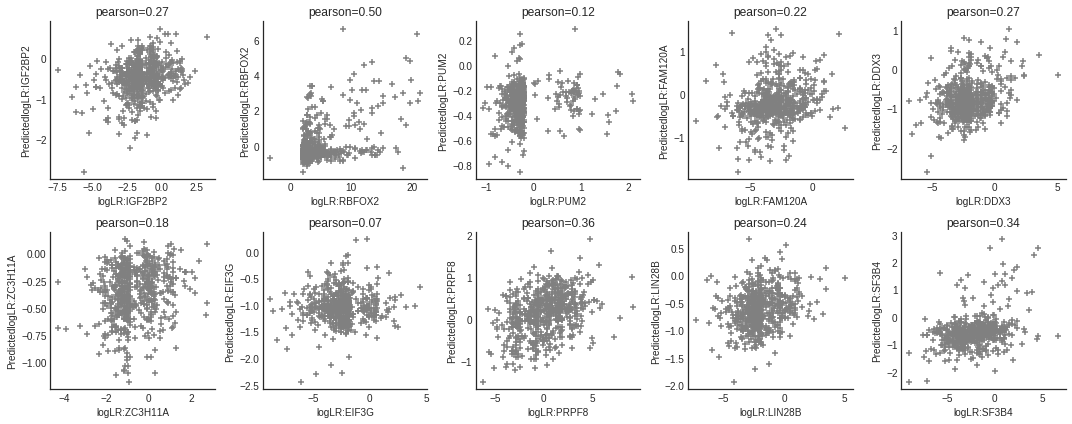

In [21]:
wt_pearson = plot_pearson_correlation(y_pred, target_df, targets_wt)

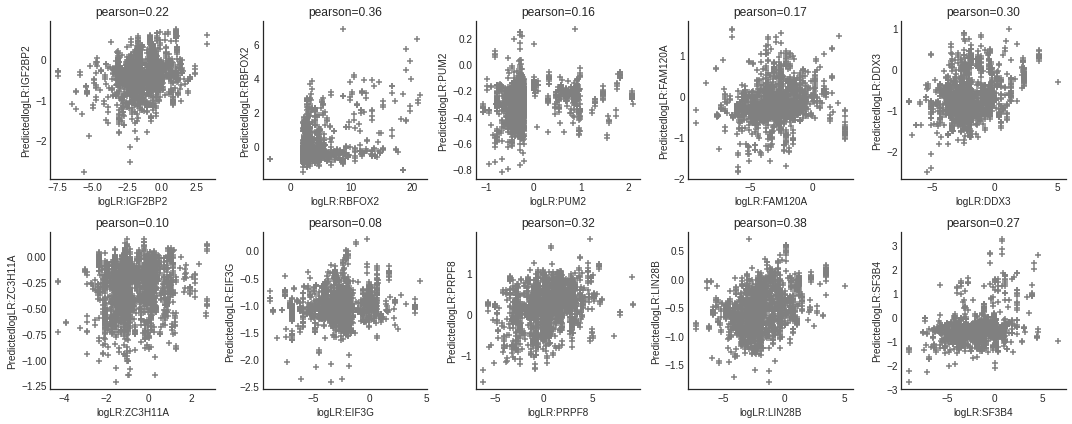

In [22]:
var_pearson = plot_pearson_correlation(y_pred_var, target_df, targets_var)

In [23]:
y_pred_var_df = pd.DataFrame(y_pred_var, index = variants.index, columns = target_df.columns)
y_pred_wt_df = pd.DataFrame(y_pred, index = seq['name'], columns = target_df.columns)

In [24]:
# map to variants dataframe
variants[f'variant_score_{rbp}'] = y_pred_var_df[f'logLR:{outstem}.{rbp}']
variants[f'wt_score_{rbp}'] = variants['name'].map(y_pred_wt_df[f'logLR:{outstem}.{rbp}'])

<AxesSubplot:ylabel='Frequency'>

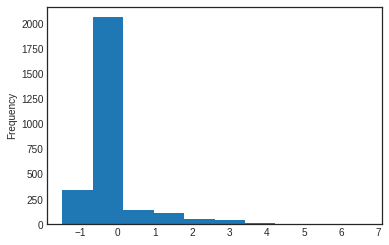

In [25]:
variants[f'wt_score_{rbp}'].plot.hist()

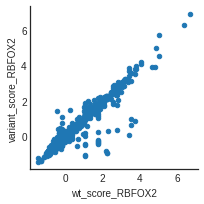

In [26]:
variants.plot.scatter(x = f'wt_score_{rbp}', y = f'variant_score_{rbp}', figsize = (3,3))
sns.despine()

In [27]:
variants['delta_score'] = (variants[f'variant_score_{rbp}']-variants[f'wt_score_{rbp}'])

<AxesSubplot:>

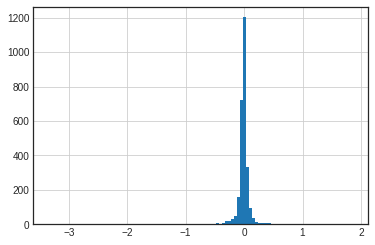

In [28]:
variants['delta_score'].hist(bins = 100)

In [29]:
variants

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/CLNDN,INFO/CLNVC,INFO/CLNSIG,variant_score_RBFOX2,wt_score_RBFOX2,delta_score
0,0,chr1,1042400,677947,C,T,665,GGCCTTGTCCAGGCTCCCTGGTCCCTGACCTCAGCCATGCCCTCCC...,SS5_PROX,SS5_PROX:INTRON,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_provided,single_nucleotide_variant,Benign,1.359127,1.339045,0.020083
1,1,chr1,1045444,703636,G,A,703,GGGAGGCCTCAGGTGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_provided,single_nucleotide_variant,Likely_benign,-0.407297,-0.384395,-0.022903
2,2,chr1,1045444,190974,G,C,703,GGGCGGCCTCAGGTGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_specified,single_nucleotide_variant,Benign/Likely_benign,-0.415224,-0.384395,-0.030830
3,3,chr1,1045453,2043252,G,A,703,GGGGGGCCTCAGATGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8,single_nucleotide_variant,Likely_benign,-0.382221,-0.384395,0.002173
4,4,chr1,1045460,210107,C,T,703,GGGGGGCCTCAGGTGTGACTGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,not_specified|Congenital_myasthenic_syndrome_8,single_nucleotide_variant,Uncertain_significance,-0.394475,-0.384395,-0.010080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,2941,chr9,137113943,2409939,G,A,3244610,TGGTCGACTTCGCAGAGCTGCTCCGCGCGCTACGACGCGACCTCGG...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.504071,-0.532006,0.027935
2808,2942,chr9,137114501,2402599,A,G,3244618,ACTTCAACTTCGAGCGCTCCGGCAACAAGACCTTCCCTCAGCGCTT...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.512935,-0.514889,0.001954
2809,2943,chr9,137114504,2357771,C,G,3244618,ACTTCAACTTCGAGCCCTTCGGCAACAAGACCTTCCCTCAGCGCTT...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.517204,-0.514889,-0.002315
2810,2944,chr9,137114538,2308862,A,G,3244619,CCCGCAGGGCCCCGGACCCCGGCTTCCAGGAGCGCTTCCTCCAGCA...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.348769,-0.344980,-0.003789


<AxesSubplot:title={'center':'delta_score'}, xlabel='INFO/CLNSIG'>

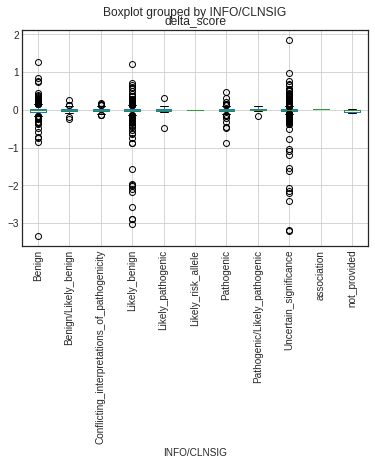

In [30]:
variants.boxplot(by = 'INFO/CLNSIG', column = 'delta_score', rot = 90)

In [38]:
variants

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/CLNDN,INFO/CLNVC,INFO/CLNSIG,variant_score_RBFOX2,wt_score_RBFOX2,delta_score
0,0,chr1,1042400,677947,C,T,665,GGCCTTGTCCAGGCTCCCTGGTCCCTGACCTCAGCCATGCCCTCCC...,SS5_PROX,SS5_PROX:INTRON,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_provided,single_nucleotide_variant,Benign,1.359127,1.339045,0.020083
1,1,chr1,1045444,703636,G,A,703,GGGAGGCCTCAGGTGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_provided,single_nucleotide_variant,Likely_benign,-0.407297,-0.384395,-0.022903
2,2,chr1,1045444,190974,G,C,703,GGGCGGCCTCAGGTGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8|not_specified,single_nucleotide_variant,Benign/Likely_benign,-0.415224,-0.384395,-0.030830
3,3,chr1,1045453,2043252,G,A,703,GGGGGGCCTCAGATGTGACCGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,Congenital_myasthenic_syndrome_8,single_nucleotide_variant,Likely_benign,-0.382221,-0.384395,0.002173
4,4,chr1,1045460,210107,C,T,703,GGGGGGCCTCAGGTGTGACTGCTGTGAGCCTGGCTTCTGGAACTTT...,CDS,CDS:EXON_MRNA,AGRN,protein_coding,protein_coding,not_specified|Congenital_myasthenic_syndrome_8,single_nucleotide_variant,Uncertain_significance,-0.394475,-0.384395,-0.010080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,2941,chr9,137113943,2409939,G,A,3244610,TGGTCGACTTCGCAGAGCTGCTCCGCGCGCTACGACGCGACCTCGG...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.504071,-0.532006,0.027935
2808,2942,chr9,137114501,2402599,A,G,3244618,ACTTCAACTTCGAGCGCTCCGGCAACAAGACCTTCCCTCAGCGCTT...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.512935,-0.514889,0.001954
2809,2943,chr9,137114504,2357771,C,G,3244618,ACTTCAACTTCGAGCCCTTCGGCAACAAGACCTTCCCTCAGCGCTT...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.517204,-0.514889,-0.002315
2810,2944,chr9,137114538,2308862,A,G,3244619,CCCGCAGGGCCCCGGACCCCGGCTTCCAGGAGCGCTTCCTCCAGCA...,CDS,CDS:EXON_MRNA,DPP7,protein_coding:retained_intron,protein_coding,Inborn_genetic_diseases,single_nucleotide_variant,Uncertain_significance,-0.348769,-0.344980,-0.003789


In [40]:
variants.loc[variants['delta_score']<-0.5][['gene_name','INFO/CLNDN', 'INFO/CLNSIG', 'feature_type_top']]

,gene_name,INFO/CLNDN,INFO/CLNSIG,feature_type_top
104,AMPD2,not_provided|Pontocerebellar_hypoplasia_type_9...,Benign,SSB_ADJ
274,CCND2,not_provided,Likely_benign,SS5_PROX
310,SLC25A3,not_provided,Likely_benign,CDS_STOP
354,CHTF18,Inborn_genetic_diseases,Uncertain_significance,CDS
413,ZNF276,Fanconi_anemia,Likely_benign,UTR3
490,KISS1R,not_provided,Likely_benign,SS5_PROX
495,NDUFS7,not_provided,Benign,SS5_PROX
496,NDUFS7,not_provided,Benign,SS5_PROX
533,AMH,not_provided,Benign,EXON_MRNA
717,POLD1,"Colorectal_cancer,_susceptibility_to,_10",Uncertain_significance,SS5_ADJ


In [34]:
variants.to_csv(f'../data/variant_clinvar/{rbp}.variant_score.csv')

In [49]:
spliceai = pd.read_csv('/home/hsher/data/POLD1.output.vcf', comment = '#', sep = '\t',
                      names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', '.', '.2', 'INFO'])

In [66]:
spliceai.loc[(spliceai['CHROM']=='chr19')&(spliceai['POS']<=50408921)&(spliceai['POS']>=50408919), 
             'INFO'].str.split('SpliceAI=', expand = True)[1]

2472      C|POLD1|0.00|0.00|0.00|0.00|-25|-18|3|-21
2473      T|POLD1|0.00|0.00|0.00|0.00|-25|-50|3|-21
2474      T|POLD1|0.00|0.00|0.59|0.01|-26|46|-2|-19
2475     C|POLD1|0.00|0.00|0.00|0.00|14|-27|-23|-20
2476     G|POLD1|0.00|0.00|0.01|0.00|-27|-13|-1|-20
2477    T|POLD1|0.00|0.00|0.00|0.00|-27|-20|-20|-23
Name: 1, dtype: object

In [75]:
score = spliceai['INFO'].str.split('SpliceAI=', expand = True)[1].str.split(',',expand = True)[0].str.split('|', expand = True)
score.columns = 'ALLELE|SYMBOL|DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL'.split('|')

In [83]:
score.replace('.', None, inplace = True)

ALLELE    None
SYMBOL    None
DS_AG     None
DS_AL     None
DS_DG     None
DS_DL     None
DP_AG     None
DP_AL     None
DP_DG     None
DP_DL     None
dtype: object

In [84]:
score['DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL'.split('|')] = score['DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL'.split('|')].astype(float)

<AxesSubplot:>

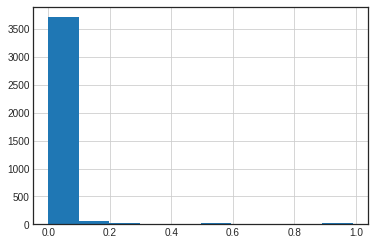

In [86]:
score['DS_DG'].hist()

In [91]:
score = pd.concat([spliceai, score], axis = 1)

In [94]:
score.loc[score['DS_DG']>0.5, 'INFO'].values

array(['ALLELEID=410669;CLNDISDB=MedGen:CN517202;CLNDN=not_provided;CLNHGVS=NC_000019.10:g.50384391G>C;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;CLNVI=ClinGen:CA16620882;GENEINFO=POLD1:5424;MC=SO:0001575|splice_donor_variant;ORIGIN=1;RS=1064794875;SpliceAI=C|POLD1|0.00|0.00|0.60|0.99|40|-1|40|-1',
       'ALLELEID=847922;CLNDISDB=MONDO:MONDO:0012953,MedGen:C2675481,OMIM:612591,Orphanet:220460;CLNDN=Colorectal_cancer,_susceptibility_to,_10;CLNHGVS=NC_000019.10:g.50399030C>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=POLD1:5424;MC=SO:0001587|nonsense,SO:0001619|non-coding_transcript_variant;ORIGIN=1;RS=2038482013;SpliceAI=G|POLD1|0.00|0.00|0.61|0.06|-3|-32|-3|23',
       'ALLELEID=1034443;CLNDISDB=MONDO:MONDO:0012953,MedGen:C2675481,OMIM:612591,Orphanet:220460;CLNDN=Colorectal_cancer,_susceptibility_to,_10;CLNH

In [54]:
spliceai.loc[spliceai['POS']==50408920]['INFO'].values[0]
#ALLELE|SYMBOL|DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL
#T|POLD1|

# DS_AG:0.00
# DS_AL:0.00
# DS_DG:0.59
# DS_DL:0.01
# DP_AG:-26
# DP_AL:46
# DP_DG:-2
#DP_DLL-19

# anges from 0 to 1 and can be interpreted as the probability of the variant being splice-altering. In the paper, a detailed characterization is provided for 0.2 (high recall), 0.5 (recommended), and 0.8 (high precision) cutoffs. Delta position conveys information about the location where splicing changes relative to the variant position (positive values are downstream of the variant, negative values are upstream).

TypeError: unsupported operand type(s) for |: 'float' and 'float'

In [55]:
variants.loc[variants['gene_name']=='POLD1']

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/CLNDN,INFO/CLNVC,INFO/CLNSIG,variant_score_RBFOX2,wt_score_RBFOX2,delta_score
715,1434,chr19,50384437,677917,G,C,5290126,GTGAGTAGAGGGGAAAAAGGGAGTTCGGGGCAGTGGGCCTGGTAGG...,SS5_ADJ,SS5_ADJ:SS5_PROX:INTRON,POLD1,protein_coding:retained_intron,protein_coding,not_provided,single_nucleotide_variant,Benign,-0.139869,-0.092990,-0.046879
716,1435,chr19,50384466,1200359,A,G,5290126,GTGAGTAGAGGGGAAAAAGGGAGTTCGGGGCAGTGGGCCTGGTAGG...,SS5_ADJ,SS5_ADJ:SS5_PROX:INTRON,POLD1,protein_coding:retained_intron,protein_coding,not_provided,single_nucleotide_variant,Likely_benign,-0.065295,-0.092990,0.027694
717,1436,chr19,50408905,1464267,TA,T,5290388,GTATGTGCCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCCT...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Colorectal_cancer,_susceptibility_to,_10",Deletion,Uncertain_significance,1.245709,1.761288,-0.515579
718,1437,chr19,50408906,567510,A,G,5290388,GTATGGTGCCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Colorectal_cancer,_susceptibility_to,_10",single_nucleotide_variant,Uncertain_significance,1.742282,1.761288,-0.019006
720,1439,chr19,50408908,537144,T,A,5290388,GTATAGAGCCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,Hereditary_cancer-predisposing_syndrome|Colore...,single_nucleotide_variant,Likely_benign,1.581324,1.761288,-0.179964
721,1440,chr19,50408909,1122868,G,A,5290388,GTATAGTACCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Colorectal_cancer,_susceptibility_to,_10",single_nucleotide_variant,Likely_benign,1.675083,1.761288,-0.086205
722,1441,chr19,50408910,414795,C,G,5290388,GTATAGTGGCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Malignant_tumor_of_breast|Colorectal_cancer,_s...",single_nucleotide_variant,Likely_benign,1.549518,1.761288,-0.211770
723,1442,chr19,50408910,796628,C,T,5290388,GTATAGTGTCCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Colorectal_cancer,_susceptibility_to,_10",single_nucleotide_variant,Likely_benign,1.633286,1.761288,-0.128002
724,1443,chr19,50408911,391591,C,T,5290388,GTATAGTGCTCAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"Colorectal_cancer,_susceptibility_to,_10|not_s...",single_nucleotide_variant,Likely_benign,1.437661,1.761288,-0.323627
725,1444,chr19,50408912,371994,C,T,5290388,GTATAGTGCCTAATTCAGCATGTGTCCCCCGAGGCCCATCTGGGCC...,SS5_ADJ,SS5_ADJ:SSB_PROX:SS3_PROX:SS5_PROX:INTRON,POLD1,protein_coding,protein_coding,"not_specified|Colorectal_cancer,_susceptibilit...",single_nucleotide_variant,Likely_benign,1.602264,1.761288,-0.159024
